In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math
from tqdm.notebook import tqdm
import copy

import csv
import re

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from einops import rearrange, reduce, repeat

In [3]:
import parser
import transformer
import longrange
import dataset
import train
import util

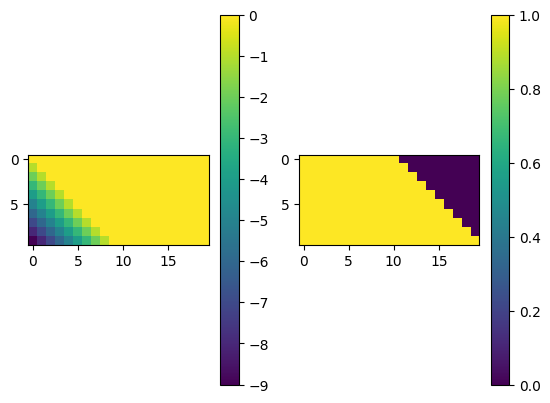

In [42]:
"""
Original Implementation by me for self attention
"""
# def get_alibi_mat(seq_len=10, n_heads=10, dtype=torch.float, device='cpu'):
#     a = torch.stack([torch.arange(i, i+seq_len, dtype=dtype, device=device) for i in range(0, -seq_len, -1)])
#     m = 2.**(-8./n_heads)
#     # m = 1.
#     m = m**torch.arange(1, n_heads+1, dtype=dtype, device=device)
#     a = m[:, None, None]*a
#     return a

"""
for self-attn, cross-attn, etc.

if attn_type is 'self':
    self attn pattern
elif attn_type is 'zero':
    all zeros
elif attn_type is 'self-memory':
    two self attn patterns (concated)
    
attn_type should be either self, selfcross, or cross
"""
def get_alibi_mat(seq_len_in=10, seq_len_out=10, attn_type='self', alibi=True, n_heads=10, dtype=torch.float, device='cpu'):
    assert seq_len_in >= seq_len_out
    
    # perceiver attn
    # regular n*n self attn
    # full cross attn
    # doublecausal attn
    if attn_type=='perceiver':
        a = torch.ones(seq_len_out, seq_len_in)-torch.eye(seq_len_out, seq_len_in)
        a = -torch.tril(a).cumsum(dim=-2)
        mask = torch.tril(torch.ones(seq_len_out, seq_len_in, dtype=bool, device=device), diagonal=seq_len_in-seq_len_out)
    elif attn_type=='zero':
        a = torch.zeros(seq_len_out, seq_len_in, dtype=dtype, device=device)
        mask = torch.ones(seq_len_out, seq_len_in, dtype=bool, device=device)
    elif attn_type=='self':
        a = torch.ones(seq_len_out, seq_len_in)-torch.eye(seq_len_out, seq_len_in)
        # a = -torch.tril(a).cumsum(dim=-2)-torch.triu(a).cumsum(dim=-1)
        a = -torch.tril(a).cumsum(dim=-2)
        mask = torch.tril(torch.ones(seq_len_out, seq_len_in, dtype=bool, device=device), diagonal=0)
    elif attn_type=='self-memory':
        a = torch.ones(seq_len_out, seq_len_in)-torch.eye(seq_len_out, seq_len_in)
        # a = -torch.tril(a).cumsum(dim=-2)-torch.triu(a).cumsum(dim=-1)
        a = -torch.tril(a).cumsum(dim=-2)
        a[:, seq_len_out:] = a[:, [0]]-1
        mask1 = torch.tril(torch.ones(seq_len_out, seq_len_out, dtype=bool, device=device), diagonal=0)
        mask2 = torch.ones(seq_len_out, seq_len_in-seq_len_out, dtype=bool, device=device)
        mask = torch.cat([mask1, mask2], dim=-1)
    else:
        raise NotImplementedError(f'{attn_type} not implemented')
        # a = torch.ones(seq_len_out, seq_len_in)-torch.eye(seq_len_out, seq_len_in)
        # # a = -torch.tril(a).cumsum(dim=-2)-torch.triu(a).cumsum(dim=-1)
        # a = -torch.tril(a).cumsum(dim=-2)
        
    # a = a-torch.inf*~mask
    # a.masked_fill_(~mask, -torch.inf)
    
    m = 2.**(-8./n_heads)
    # m = 1.
    m = m**torch.arange(1, n_heads+1, dtype=dtype, device=device)
    # a = m[:, None, None]*a
    return a, mask

def get_mask(attn, alibi=None, mask='full'):
    _, bs, nx, ny = attn.shape # output, input
    if mask == 'full':
        mask = torch.ones(bs, nx, ny, dtype=bool, device=attn.device)
    if mask == 'causal':
        mask = ~torch.tril(torch.ones(nx, ny, dtype=bool, device=attn.device), diagonal=ny-nx)
    if mask == 'doublecausal':
        # cross attention but don't attend to stuff ahead in the other seq
        ny = nx
        mask = ~torch.tril(torch.ones(nx, ny, dtype=bool, device=attn.device), diagonal=ny-nx)
        mask = torch.cat([mask, mask], dim=-1)

# plt.imshow(get_alibi_mat(32, 8)[1])
# plt.colorbar()
a, mask = get_alibi_mat(20, 10, attn_type='perceiver')
plt.subplot(121); plt.imshow(a); plt.colorbar()
plt.subplot(122); plt.imshow(mask); plt.colorbar()
# get_alibi_mat(10, 5, attn_type='self-memory')